# 📊 Threshold Tuning Evaluation for Phishing Detection

In cybersecurity applications, the decision threshold for a classifier is not just a technical detail — it's a policy decision. This notebook helps evaluate how adjusting the decision threshold affects model performance metrics like precision, recall, and F1-score across three classifiers trained for phishing detection.

By systematically analyzing these thresholds, we aim to:
- Understand trade-offs between catching phishing attempts vs. avoiding false alarms.
- Identify thresholds that are operationally safe (high recall) vs. optimal (high F1).
- Empower cybersecurity analysts to tune ML models for real-world risk settings.

## 🔹 Step 1: Load Data and Models

In this step, we load the phishing dataset and the three trained classifiers: Logistic Regression, Random Forest, and XGBoost.
We also ensure that labels are correctly interpreted, where `1 = phishing` and `0 = legitimate`. This setup is crucial for downstream binary classification evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df = pd.read_csv('../data/phishing.csv')
X = df.drop('Result', axis=1)
y = df['Result'].replace({1: 1, -1: 0})  # ✅ 1 = phishing, 0 = legitimate

# Load models
model_lr = joblib.load('../models/phishing_model_lr.pkl')
model_rf = joblib.load('../models/phishing_model_rf.pkl')
model_xgb = joblib.load('../models/phishing_model_xgb.pkl')

## 🔹 Step 2: Define Threshold Evaluation Function

This function takes a model and evaluates it across thresholds from 0.0 to 1.0. For each threshold, it computes accuracy, precision, recall, and F1-score.
This allows us to identify the trade-offs between model performance metrics as the threshold changes.

In [2]:
def evaluate_thresholds(model, X, y, model_name):
    thresholds = np.arange(0.0, 1.01, 0.01)
    scores = []
    probs = model.predict_proba(X)[:, 1]  # Probability for class '1' (phishing)

    for t in thresholds:
        preds = (probs >= t).astype(int)
        scores.append([
            t,
            accuracy_score(y, preds),
            precision_score(y, preds, zero_division=0),
            recall_score(y, preds, zero_division=0),
            f1_score(y, preds, zero_division=0)
        ])

    return pd.DataFrame(scores, columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1']).assign(Model=model_name)

## 🔹 Step 3: Run Threshold Evaluations

Here we apply the evaluation function to each model and concatenate the results for comparison. This data will be used for further visualization and analysis.

In [3]:
results_lr = evaluate_thresholds(model_lr, X, y, 'Logistic Regression')
results_rf = evaluate_thresholds(model_rf, X, y, 'Random Forest')
results_xgb = evaluate_thresholds(model_xgb, X, y, 'XGBoost')

all_results = pd.concat([results_lr, results_rf, results_xgb])

## 🔹 Step 4: Visualize F1 Score vs Threshold

We now plot the F1-score against thresholds for each model. F1-score helps capture the balance between precision and recall, which is essential in phishing detection.
This visual helps in identifying the threshold at which each model performs optimally.

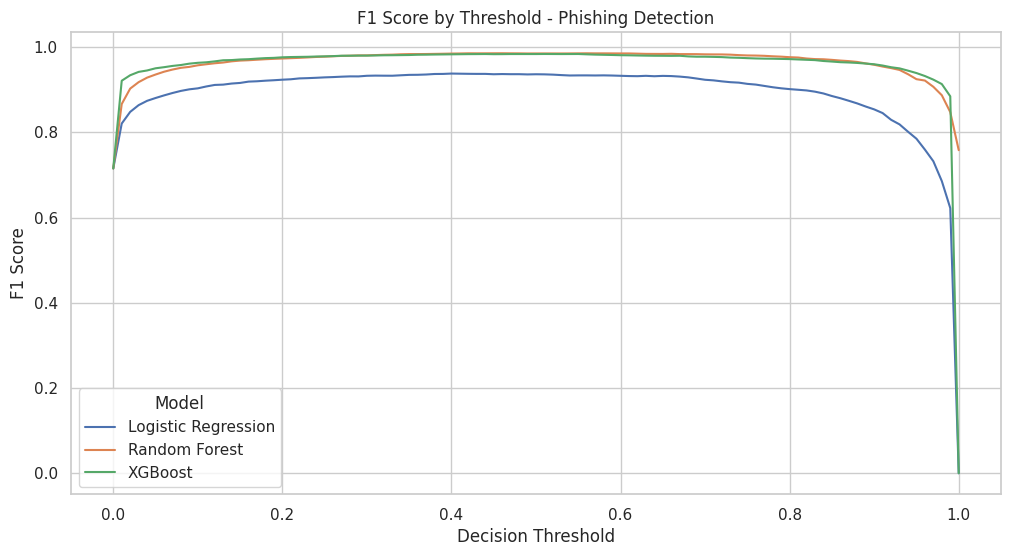

In [4]:
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_results, x='Threshold', y='F1', hue='Model')
plt.title('F1 Score by Threshold - Phishing Detection')
plt.ylabel('F1 Score')
plt.xlabel('Decision Threshold')
plt.grid(True)
plt.show()

## 🔹 Step 5: Reflection and Analysis

Let's explore three cybersecurity-relevant questions using the threshold evaluation results.

### 🔍 Q1: At what threshold is your model most balanced?

We select the threshold with the highest F1-score for each model — this typically reflects the point at which the model is most balanced between precision and recall.

In [5]:
best_thresholds = (
    all_results.loc[all_results.groupby('Model')['F1'].idxmax()]
    [['Model', 'Threshold', 'F1']]
    .reset_index(drop=True)
)
print("🔍 Best threshold per model based on F1 score:")
print(best_thresholds)

🔍 Best threshold per model based on F1 score:
                 Model  Threshold        F1
0  Logistic Regression       0.40  0.938062
1        Random Forest       0.40  0.984988
2              XGBoost       0.40  0.983217
3  Logistic Regression       0.46  0.936920
4        Random Forest       0.46  0.985745
5              XGBoost       0.46  0.983630
6  Logistic Regression       0.51  0.936205
7        Random Forest       0.51  0.985280
8              XGBoost       0.51  0.984001


### 🛡️ Q2: What threshold would be safest in a cybersecurity scenario?

In high-stakes scenarios like phishing detection, **recall** is more critical — we prefer to catch as many phishing attempts as possible, even if it means more false positives.
Here, we list the threshold for each model that achieves **recall ≥ 0.95** with the best possible precision.

In [6]:
high_recall_thresholds = (
    all_results[all_results['Recall'] >= 0.95]
    .sort_values(['Model', 'Precision'], ascending=[True, False])
)
print("🛡️ Thresholds with Recall ≥ 0.95:")
print(high_recall_thresholds.groupby('Model').head(1))

🛡️ Thresholds with Recall ≥ 0.95:
    Threshold  Accuracy  Precision    Recall        F1                Model
46       0.46  0.928720   0.923757  0.950463  0.936920  Logistic Regression
80       0.80  0.974310   0.996450  0.957284  0.976474        Random Forest
80       0.80  0.969516   0.993722  0.951275  0.972036              XGBoost


### ⚖️ Q3: Would you prioritize catching all phishing or reducing false alarms?

This decision depends on operational needs. Here we plot the trade-off between precision and recall to visualize which model offers a good compromise or excels in one over the other.

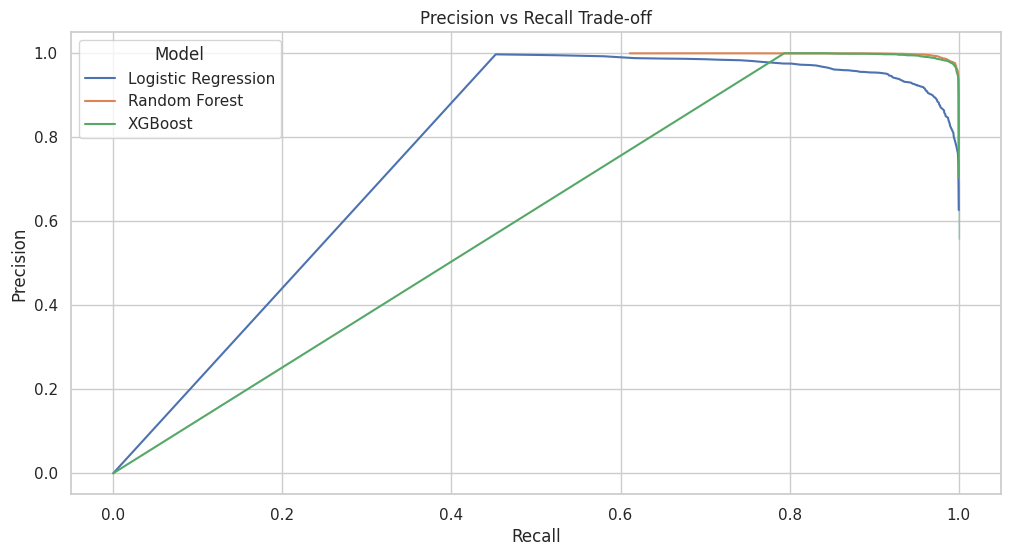

In [7]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_results, x='Recall', y='Precision', hue='Model')
plt.title('Precision vs Recall Trade-off')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()